
## Exploration Phase - Non Linear Models & Model Selection

**GOAL**: Create a Classification Model that can predict whether or not a person would buy an item we offered them (via push notification) based on behavioral and personal features of that user (user id, ordered before, etc), features of that specific order (date, etc) and features of the items themselves (popularity, price, avg days to buy, etc)

We must notice that sending too many notifications would have a negative impact on user experience.

**MODULE 4 GOAL: We will now continue the work done in Module 3 and keep exploring models, now focusing on non linear ones.**

At the end, we will select the best performing model (among baseline, linear and non linear models)

### **STRUCTURE OF THIS NOTEBOOK**

- Split the data, create Baseline model
- Non Linear models exploration with different hyperparameters: Random Forests, Gradient Boosting Trees, CatBoost, XGBoost
- Final comparison of all models & saving the best performing one

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple
import joblib
import os

from pathlib import Path
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import(
    average_precision_score,
    log_loss,
    precision_recall_curve,
    precision_recall_fscore_support
)
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

from catboost import Pool
from catboost import CatBoostClassifier



In [3]:
path = '/home/carleondel/data-zrive-ds/box_builder_dataset/'
df = pd.read_csv(path + 'feature_frame.csv')

We already explored our dataset so we will jump directly into splitting it

### Data splitting
- Before splitting we need to filter our df to keep only orders with more than 5 items
- Then we make a temporal split of 70-20-10 for train | validation | test
- Finally we make the X | y splits

In [4]:
def push_relevant_dataframe(df: pd.DataFrame, min_products: int=5) -> pd.DataFrame:
    """We are only interested in orders with at least 5 products"""
    order_size = df.groupby('order_id').outcome.sum()
    orders_of_min_size = order_size[order_size >= min_products].index
    return df.loc[lambda x: x.order_id.isin(orders_of_min_size)]

df_selected = (
    df
    .pipe(push_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
)

In [5]:
df_selected.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [6]:
daily_orders = df_selected.groupby('order_date')['order_id'].nunique()

In [7]:
daily_orders

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     6
2020-10-08    12
2020-10-09     4
              ..
2021-02-27    32
2021-02-28    32
2021-03-01    42
2021-03-02    25
2021-03-03    14
Name: order_id, Length: 149, dtype: int64

Text(0.5, 1.0, 'Daily orders')

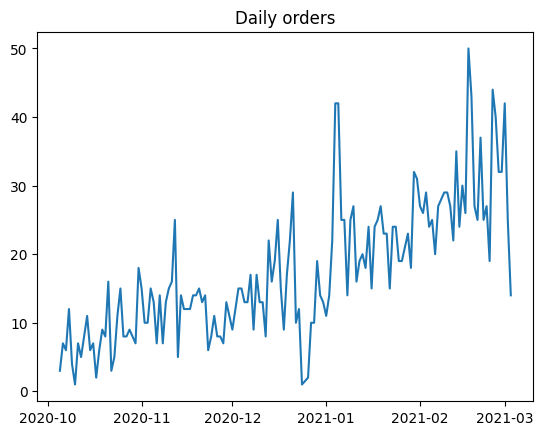

In [8]:
fig, ax = plt.subplots()
ax.plot(daily_orders, label="daily orders")
ax.set_title("Daily orders")

We already discussed in Module 3 why it makes sense to make a temporal split

In [9]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()
""" We are getting the pct of acummulated orders out of the all orders after each day"""

train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
""" Now we are taking the date of the order just before surpassing 0.7 of the total"""
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

print("Train since:", cumsum_daily_orders.index.min())
print("Train until:", train_val_cutoff)
print("Val until:", val_test_cutoff)
print("Test until:", cumsum_daily_orders.index.max())

Train since: 2020-10-05
Train until: 2021-02-04
Val until: 2021-02-22
Test until: 2021-03-03


We must notice our time splits are very narrow and we could be skewing our samples in case of rare events (Halloween, holidays, etc)

In [10]:
train_df = df_selected[df_selected['order_date'] <= train_val_cutoff]
val_df = df_selected[(df_selected['order_date'] > train_val_cutoff) & (df_selected['order_date'] <= val_test_cutoff)]
test_df = df_selected[df_selected['order_date'] > val_test_cutoff]

We make the temporal split, taking the first 70% for training, the next 20% for validation and the last 10% for test

### Explicit declaration of columns
We make our columns selection explicit in order to avoid problems in case columns names/order changed in the future

In [10]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 27 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   variant_id                        int64         
 1   product_type                      object        
 2   order_id                          int64         
 3   user_id                           int64         
 4   created_at                        datetime64[ns]
 5   order_date                        object        
 6   user_order_seq                    int64         
 7   outcome                           float64       
 8   ordered_before                    float64       
 9   abandoned_before                  float64       
 10  active_snoozed                    float64       
 11  set_as_regular                    float64       
 12  normalised_price                  float64       
 13  discount_pct                      float64       
 14  vendor                 

In [11]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
features_cols = [col for col in df.columns if col not in (info_cols + [label_col])]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

By now we will work without the categorical features and without info_cols.
In the future we can explore different types of encoding and also creating new features extracted from the datetime columns such as month, day or hour the order was made (not year since we have less than 1 full year on our dataset).

In [12]:
train_cols = numerical_cols + binary_cols

In [13]:
train_cols

['user_order_seq',
 'normalised_price',
 'discount_pct',
 'global_popularity',
 'count_adults',
 'count_children',
 'count_babies',
 'count_pets',
 'people_ex_baby',
 'days_since_purchase_variant_id',
 'avg_days_to_buy_variant_id',
 'std_days_to_buy_variant_id',
 'days_since_purchase_product_type',
 'avg_days_to_buy_product_type',
 'std_days_to_buy_product_type',
 'ordered_before',
 'abandoned_before',
 'active_snoozed',
 'set_as_regular']

Before creating our baseline model we are going to define some functions that will help us plot the different metrics we will use

In [14]:
def plot_metrics(
        model_name : str, y_pred : pd.Series, y_test : pd.Series,
        figure : Tuple[matplotlib.figure.Figure, np.array] = None
    ):
    precision_, recall_, _ = precision_recall_curve(
        y_test, y_pred
    )
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)


    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure

    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title("Precision-recall Curve")
    ax[0].legend()



    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title("ROC Curve")
    ax[1].legend()

### Baseline model
Since we are now exploring non linear models, our baseline model will be the best linear model we got in module 3, which is Ridge Regression with C=1e-6

In [15]:
def feature_label_split(df : pd.DataFrame, label_col : str ) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)

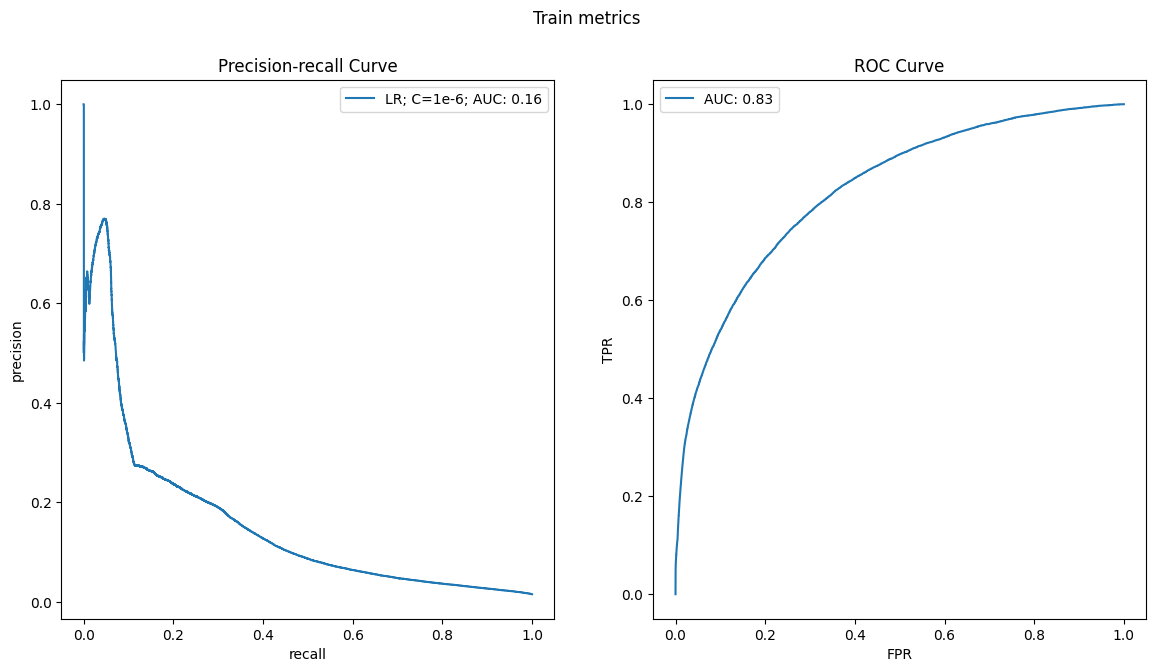

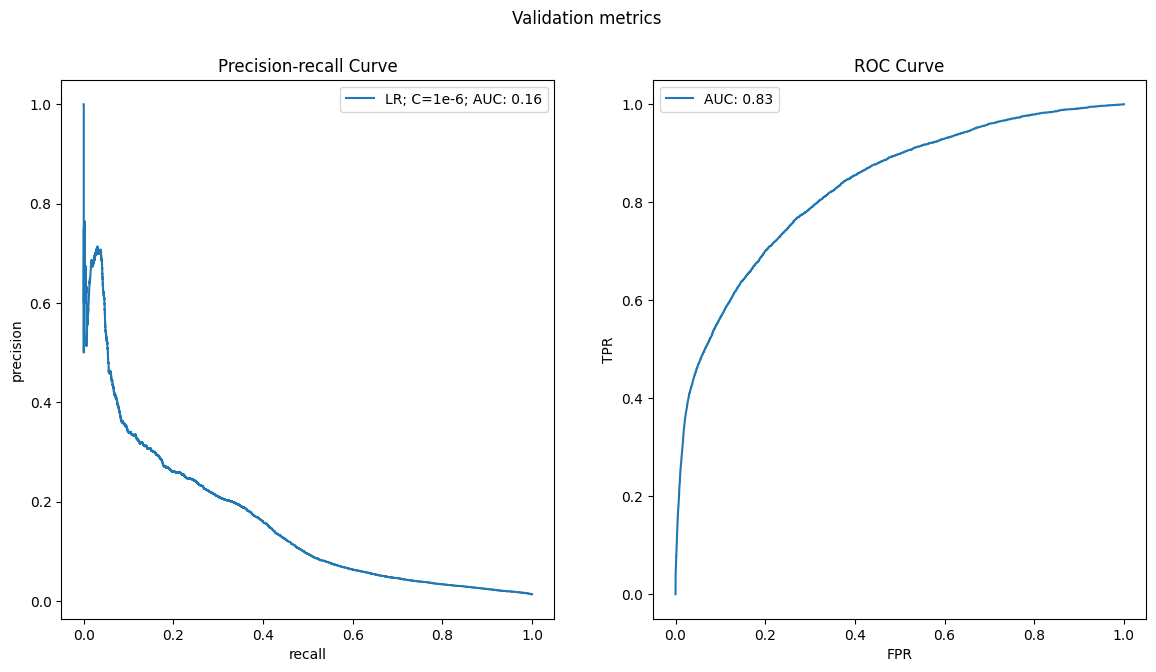

In [16]:
# We initialize the subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize = (14,7))
fig2.suptitle("Validation metrics")
    
ridge = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l2", C=1e-6)
)
ridge.fit(X_train[train_cols], y_train)

train_proba = ridge.predict_proba(X_train[train_cols])[:,1]
plot_metrics(f"LR; C=1e-6", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1))


val_proba = ridge.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(f"LR; C=1e-6", y_pred = val_proba, y_test = val_df[label_col], figure = (fig2, ax2))


In [17]:
X_train[(ridge.predict_proba(X_train[train_cols])[:,1] > 0.1)][numerical_cols]

,user_order_seq,normalised_price,discount_pct,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
87573,4,0.284359,0.138227,0.387146,2.0,0.0,0.0,0.0,2.0,6.0,25.0,19.68243,6.0,25.0,21.04899
87612,3,0.284359,0.138227,0.387146,2.0,0.0,0.0,0.0,2.0,6.0,25.0,19.68243,6.0,25.0,21.04899


We only have 2 instances classified as 1 with probabilities >10%. So we should consider lowering the threshold

In [19]:
# Obtaining class probabilities
probabilities_test = ridge.predict_proba(X_val[train_cols])

# personalized threshold
new_threshold = 0.03

# Adjust predictions by the new threshold
new_predictions = (probabilities_test[:, 1] > new_threshold).astype(int)

# Evaluate performance of the model with the new threshold
accuracy = accuracy_score(val_df[label_col], new_predictions)
precision = precision_score(val_df[label_col], new_predictions)
recall = recall_score(val_df[label_col], new_predictions)

print(f'Performance with new threshold ({new_threshold}):')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Performance with new threshold (0.03):
Accuracy: 0.99
Precision: 0.70
Recall: 0.04


In [20]:
# Obtaining class probabilities
probabilities_test = ridge.predict_proba(X_val[train_cols])

# personalized threshold
new_threshold = 0.02

# Adjust predictions by the new threshold
new_predictions = (probabilities_test[:, 1] > new_threshold).astype(int)

# Evaluate performance of the model with the new threshold
accuracy = accuracy_score(val_df[label_col], new_predictions)
precision = precision_score(val_df[label_col], new_predictions)
recall = recall_score(val_df[label_col], new_predictions)

print(f'Performance with new threshold ({new_threshold}):')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Performance with new threshold (0.02):
Accuracy: 0.98
Precision: 0.25
Recall: 0.22


In our context it makes more sense to accept more false positive cases, so we could choose a threshold between 0.03 and 0.02.

## Non-linear models
We will explore different models, including Random Forests and Gradient Boosting Trees

### Random Forest

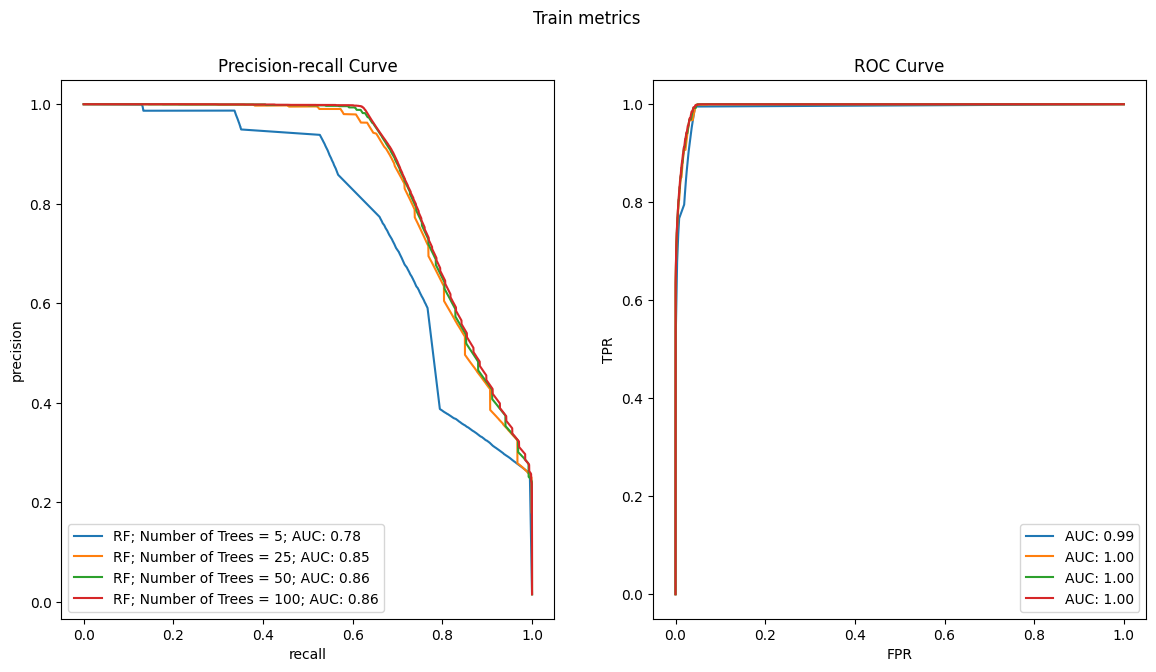

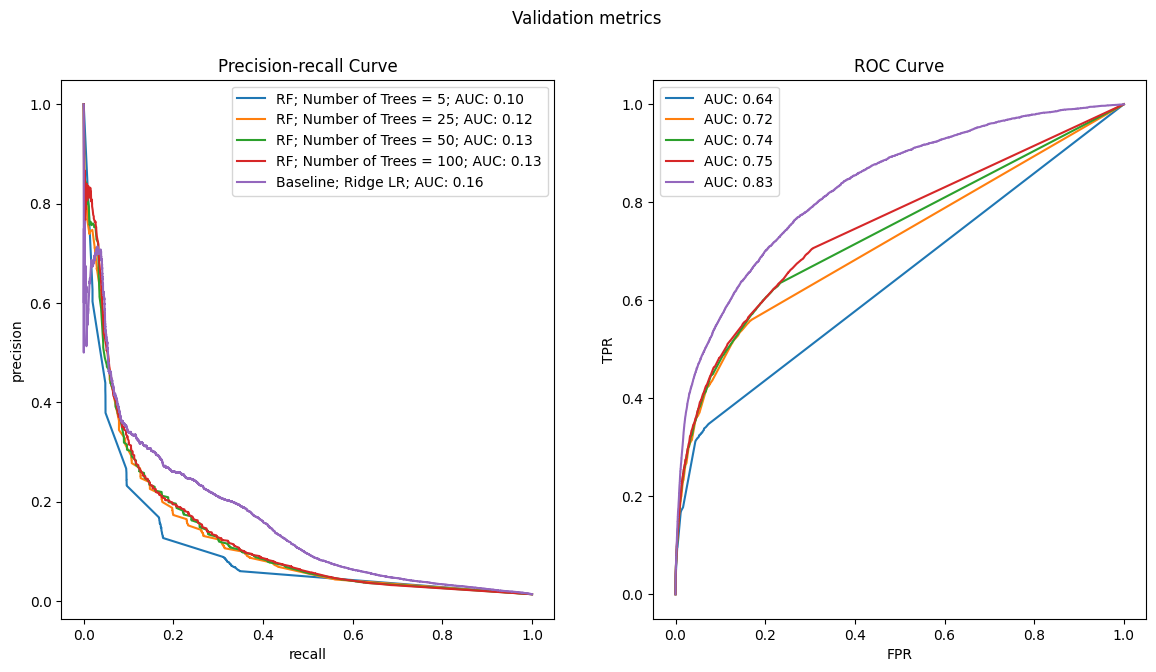

In [23]:
# We initialize the subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize = (14,7))
fig2.suptitle("Validation metrics")

# Number of trees
# In random forests we don't need to scale our training data
ns =  [5, 25, 50, 100]   
for n in ns:  
    rf = make_pipeline(
        RandomForestClassifier(n_estimators = n)
    )  
    rf.fit(X_train[train_cols], y_train)
    train_proba = rf.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(f"RF; Number of Trees = {n}", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1))


    val_proba = rf.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(f"RF; Number of Trees = {n}", y_pred = val_proba, y_test = val_df[label_col], figure = (fig2, ax2))

# We plot our baseline model ridge lr with C = 1e-6
val_proba = ridge.predict_proba(X_val[train_cols])[:, 1]    
plot_metrics(f"Baseline; Ridge LR", y_pred = val_proba, y_test = val_df[label_col], figure = (fig2, ax2))
    

### Insights 
- At first glance, we can clearly see how this model works. The performance metrics are much better on train than on validation (overfit signal). This is because each tree is built in its entirety, making the model learn some noise. But because we are averaging the predictions from multiple trees, this overfitting is reduced.
- After creating different models using different number of trees, there is not much improvement when going from 50 to 100, so it doesn't make sense to keep training with more trees.
- Overall the performance of our Random Forest models is slightly worse than the performance of our Baseline Model (Ridge C=1e-6)

### Feature Importance & Retraining
Now we are going to reduce our features and retrain our model to see if we make any improvement. Since there wasn't much improvement when moving from 50 to 100 trees, we will base our decisions on our model with 50 trees.

In [24]:
rf50 = make_pipeline(
        RandomForestClassifier(n_estimators = 50)
    )  
rf50.fit(X_train[train_cols], y_train)


# Access the model within the pipeline
rf_model = rf50.named_steps['randomforestclassifier']

# Extract importance
feature_importance = rf_model.feature_importances_

# Create df with importance
rf50_coefs_df = pd.DataFrame({'Feature': train_cols, 'Importance': feature_importance})

# Order the df
rf50_coefs_df = rf50_coefs_df.sort_values(by='Importance', ascending=False)


In [25]:
rf50_coefs_df

,Feature,Importance
3,global_popularity,0.368934
12,days_since_purchase_product_type,0.145682
0,user_order_seq,0.118486
9,days_since_purchase_variant_id,0.045590
16,abandoned_before,0.044895
11,std_days_to_buy_variant_id,0.043964
10,avg_days_to_buy_variant_id,0.037541
2,discount_pct,0.036915
15,ordered_before,0.036334
1,normalised_price,0.033050


We are going to keep the top 3 features by importance, train again and compare

In [26]:
reduced_cols = ['global_popularity', 'days_since_purchase_product_type', 'user_order_seq']

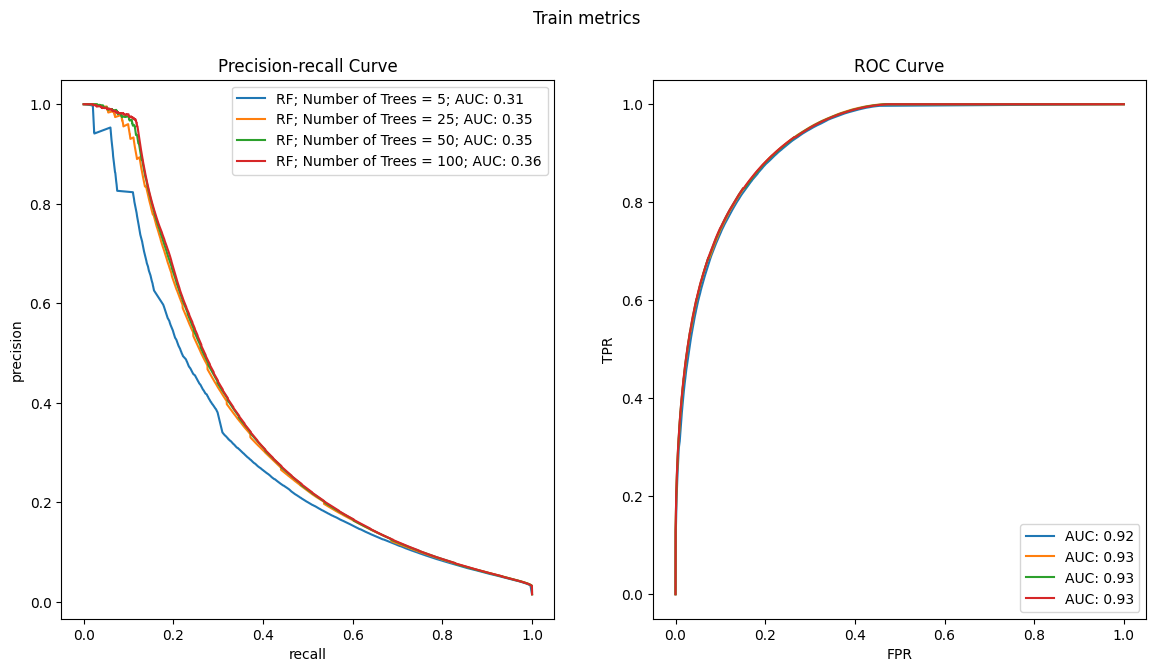

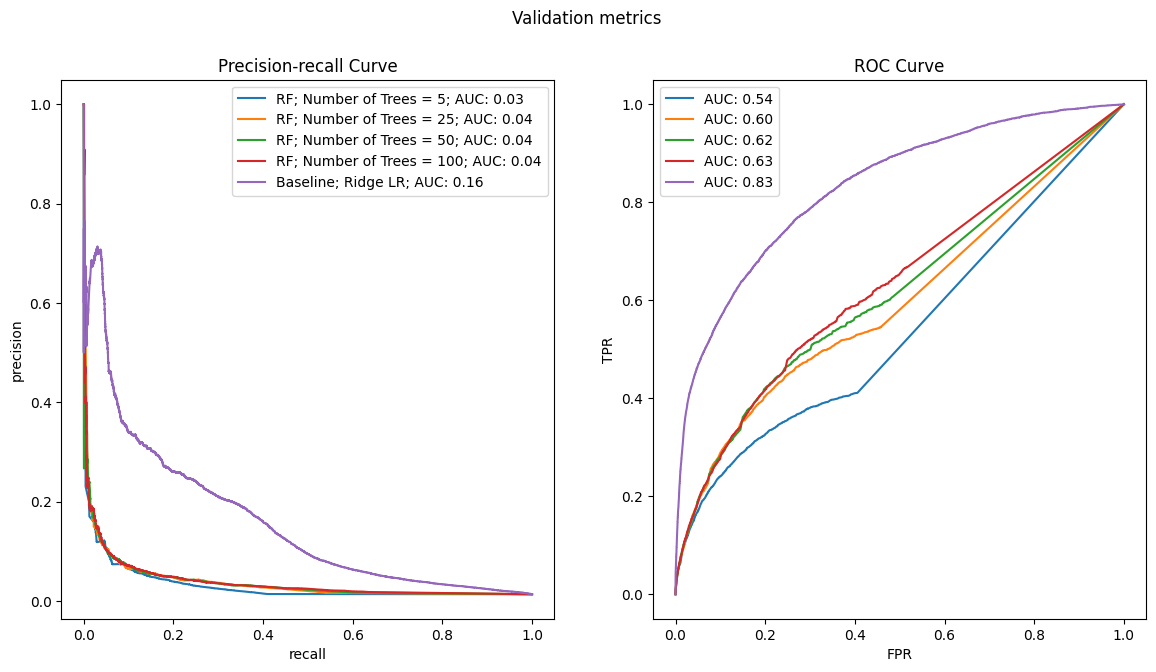

In [27]:
# We initialize the subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize = (14,7))
fig2.suptitle("Validation metrics")

# Number of trees
# In random forests we don't need to scale our training data
ns =  [5, 25, 50, 100]   
for n in ns:  
    rf = make_pipeline(
        RandomForestClassifier(n_estimators = n)
    )  
    rf.fit(X_train[reduced_cols], y_train)
    train_proba = rf.predict_proba(X_train[reduced_cols])[:, 1]
    plot_metrics(f"RF; Number of Trees = {n}", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1))


    val_proba = rf.predict_proba(X_val[reduced_cols])[:, 1]
    plot_metrics(f"RF; Number of Trees = {n}", y_pred = val_proba, y_test = val_df[label_col], figure = (fig2, ax2))

# We plot our baseline model ridge lr with C = 1e-6
val_proba = ridge.predict_proba(X_val[train_cols])[:, 1]    
plot_metrics(f"Baseline; Ridge LR", y_pred = val_proba, y_test = val_df[label_col], figure = (fig2, ax2))
    

### Insights
- The performance metrics are significantly worse than the metrics when training with all the features. (PR-AUC = 0.04 vs 0.13)

## Gradient Boosting Trees


In [45]:
'''The number of weak learners (i.e. regression trees) is controlled by
 the parameter n_estimators; 
 The size of each tree can be controlled either by setting the tree depth 
 via max_depth or by setting the number of leaf nodes via max_leaf_nodes.
 The learning_rate is a hyper-parameter in the range (0.0, 1.0] that controls
   overfitting via shrinkage .'''


'The number of weak learners (i.e. regression trees) is controlled by\n the parameter n_estimators; \n The size of each tree can be controlled either by setting the tree depth \n via max_depth or by setting the number of leaf nodes via max_leaf_nodes.\n The learning_rate is a hyper-parameter in the range (0.0, 1.0] that controls\n   overfitting via shrinkage .'

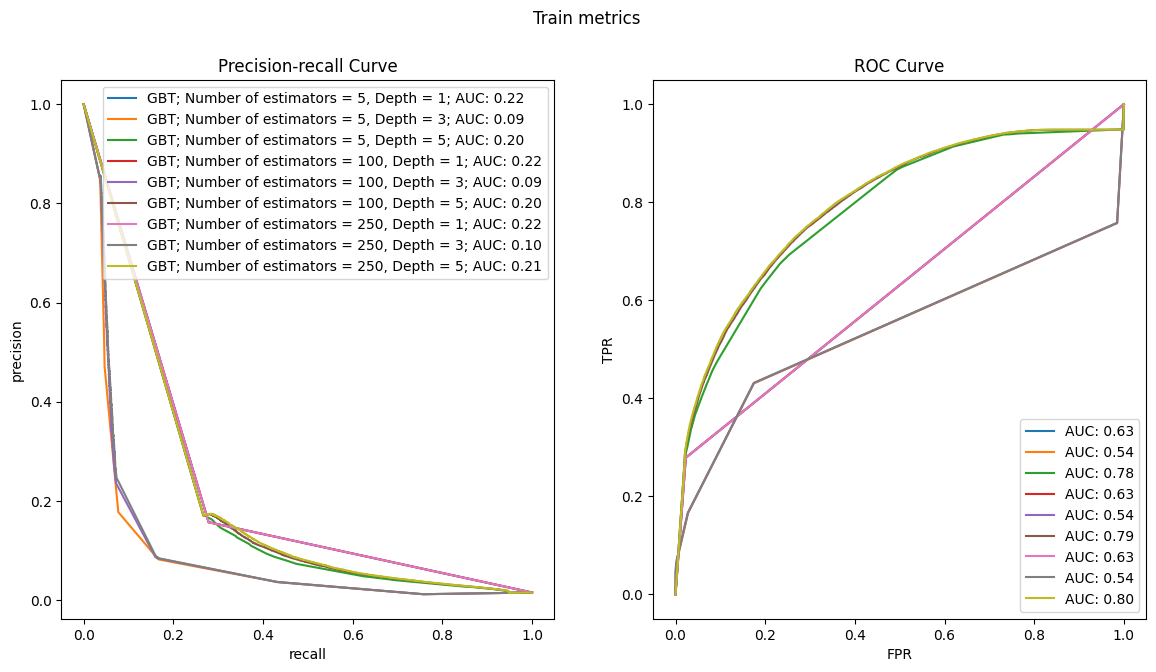

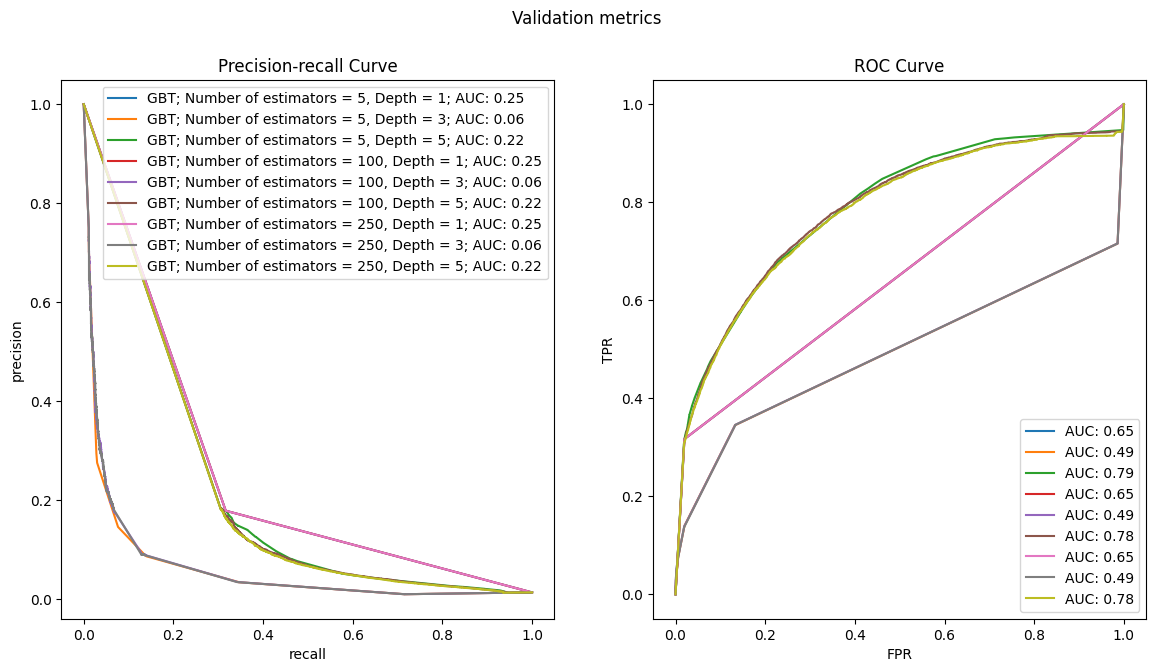

In [33]:
# We initialize the subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize = (14,7))
fig2.suptitle("Validation metrics")

# We define our parameters
ns_trees = [5,100,250]
ns_max_depth = [1,3,5]
lr = 1.0

trained_gbt_models = []
y_preds_gbt = []
gbt_model_names = []

for n_trees in ns_trees:
    for depth in ns_max_depth:
        gbt = GradientBoostingClassifier(
            n_estimators = n_trees,
            max_depth = depth,
            learning_rate = lr
            )
        gbt.fit(X_train[train_cols], y_train)

        train_proba = gbt.predict_proba(X_train[train_cols])[:, 1]
        plot_metrics(f"GBT; Number of estimators = {n_trees}, Depth = {depth}", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1))


        val_proba = gbt.predict_proba(X_val[train_cols])[:, 1]
        plot_metrics(f"GBT; Number of estimators = {n_trees}, Depth = {depth}", y_pred = val_proba, y_test = val_df[label_col], figure = (fig2, ax2))


        # We save the models and the predictions
        trained_gbt_models.append(gbt)
        y_preds_gbt.append(gbt.predict_proba(X_val[train_cols])[:, 1])
        gbt_model_names.append(f"GBT (n_trees={n_trees}, depth={depth})")

## Insights
This took >20 mins training...

Our Baseline model had PR-AUC = 0.16, ROC-AUC = 0.83. So we have finally made some improvement.
- When we used max_depth of 5, all models had a similar performance, independently of the other hyperparameter (number of estimators). PR-AUC = 0.22 and ROC-AUC = 0.79.
- So our model selected from Gradient Boosting Trees will be the one with hyperparameters: Number of estimators = 100, max_depth = 5


## Catboost

With catboost we can use our categorical features without preprocessing them.

In [17]:
catboost_cols = train_cols + categorical_cols

In [19]:
categorical_cols

['product_type', 'vendor']

0:	learn: 0.0764781	total: 343ms	remaining: 343ms
1:	learn: 0.0711741	total: 564ms	remaining: 0us


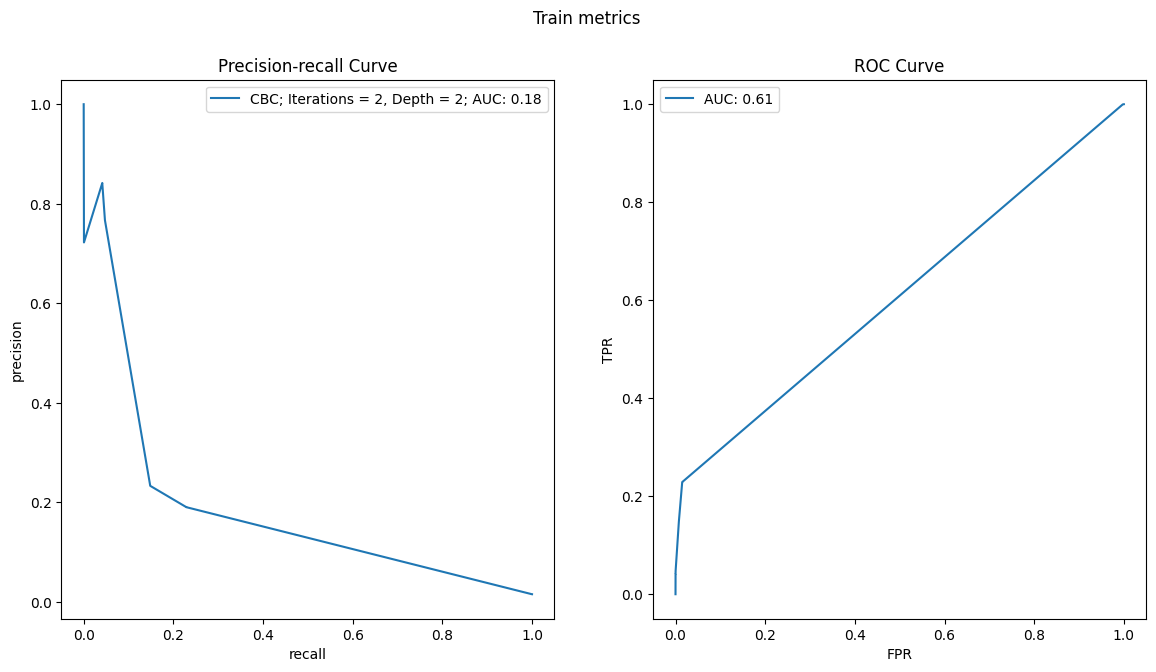

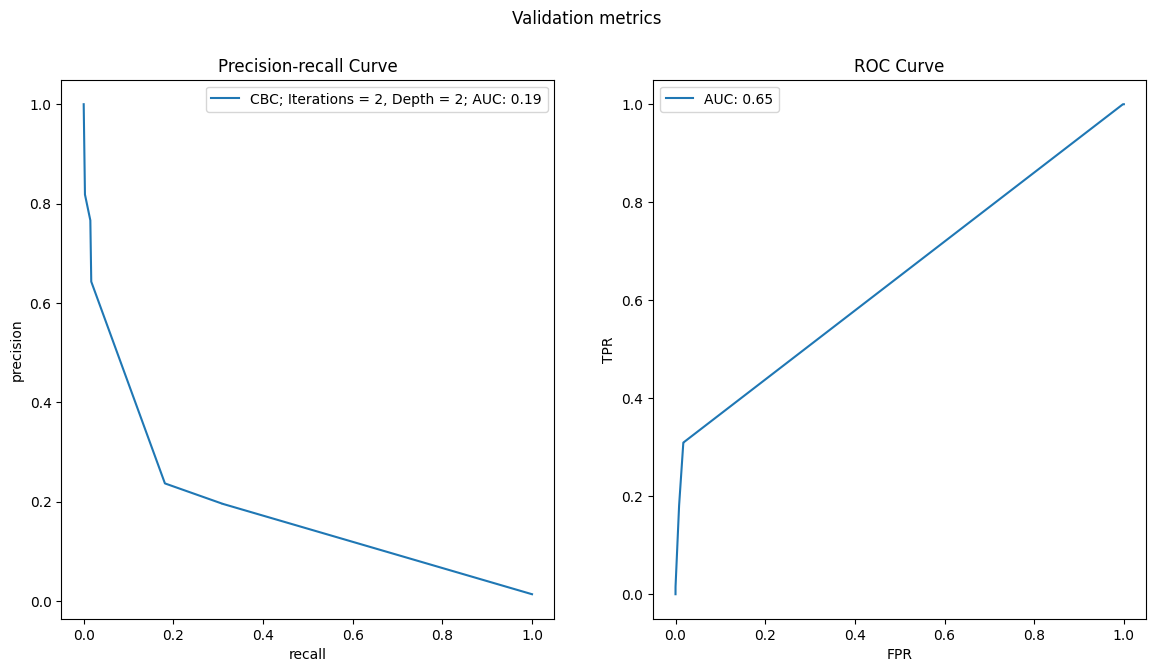

In [43]:
# Let's explore CatBoost with a simple model
# We initialize the subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize = (14,7))
fig2.suptitle("Validation metrics")


cbc = CatBoostClassifier(iterations=2,
                           learning_rate=1,
                           depth=2)
cbc.fit(X_train[catboost_cols], y_train, categorical_cols)

train_proba = cbc.predict_proba(X_train[catboost_cols])[:, 1]
plot_metrics(f"CBC; Iterations = {2}, Depth = {2}", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1))


val_proba = cbc.predict_proba(X_val[catboost_cols])[:, 1]
plot_metrics(f"CBC; Iterations = {2}, Depth = {2}", y_pred = val_proba, y_test = val_df[label_col], figure = (fig2, ax2))


In [24]:
# We create this function in order to keep track of the metrics of our grid search

def auc_score(y_test: pd.Series, y_pred: pd.Series) -> Tuple[float, float]:
    """
    Returns the ROC and PR curves AUC score for a given set of true labels and predicted probabilities.

    Args:
        y_test (array): True labels.
        y_preds (array): Predicted probabilities or scores.

    Returns:
        Tuple (float, float): ROC AUC score, PR curve AUC score.
    """
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)
    return roc_auc, pr_auc

In [26]:
# We are going to create a grid search based on my criteria
roc_scores_train = []
roc_scores_val = []

pr_scores_train = []
pr_scores_val = []

hyper_iterations = [] 
hyper_depths = []
hyper_lr = []

n = 0

for lr in [0.01, 0.05, 0.1]:
    for depth in [6, 8, 10]:
        for iterations in [100, 200, 300]:
            cbc = CatBoostClassifier(
                learning_rate = lr, depth = depth, iterations = iterations
            )
            # We need to pass the categorical cols this time
            
            cbc.fit(X_train[catboost_cols], y_train, categorical_cols)

            train_proba = cbc.predict_proba(X_train[catboost_cols])[:, 1]   
            auc_scores_train = auc_score(y_train, train_proba)
            roc_scores_train.append(auc_scores_train[0])
            pr_scores_train.append(auc_scores_train[1])

            val_proba = cbc.predict_proba(X_val[catboost_cols])[:, 1]
            auc_scores_val = auc_score(y_val, val_proba)
            roc_scores_val.append(auc_scores_val[0])
            pr_scores_val.append(auc_scores_val[1])
            
            hyper_iterations.append(iterations)
            hyper_depths.append(depth)
            hyper_lr.append(lr)

            n = n+1
            # Actualizations of the training
            print(
                f"Trained model nº {n}/27. Iterations: {iterations}"
                f"Depth: {depth}"
                f"Learning rate: {lr}"
            )



0:	learn: 0.6723575	total: 406ms	remaining: 40.2s
1:	learn: 0.6501879	total: 583ms	remaining: 28.6s
2:	learn: 0.6298137	total: 753ms	remaining: 24.4s
3:	learn: 0.6101644	total: 912ms	remaining: 21.9s
4:	learn: 0.5919772	total: 1.07s	remaining: 20.4s
5:	learn: 0.5738644	total: 1.23s	remaining: 19.3s
6:	learn: 0.5549505	total: 1.4s	remaining: 18.6s
7:	learn: 0.5388479	total: 1.55s	remaining: 17.9s
8:	learn: 0.5200021	total: 1.71s	remaining: 17.3s
9:	learn: 0.5028545	total: 1.87s	remaining: 16.8s
10:	learn: 0.4878148	total: 2.03s	remaining: 16.4s
11:	learn: 0.4732861	total: 2.18s	remaining: 16s
12:	learn: 0.4599667	total: 2.34s	remaining: 15.7s
13:	learn: 0.4463596	total: 2.49s	remaining: 15.3s
14:	learn: 0.4330468	total: 2.65s	remaining: 15s
15:	learn: 0.4204244	total: 2.81s	remaining: 14.8s
16:	learn: 0.4090390	total: 2.98s	remaining: 14.5s
17:	learn: 0.3974503	total: 3.13s	remaining: 14.3s
18:	learn: 0.3852765	total: 3.29s	remaining: 14s
19:	learn: 0.3740613	total: 3.45s	remaining: 13.

In [30]:
# We create a dictionary -> to data frame of the metrics of our grid search
hyper_search = pd.DataFrame({
    "Iterations": hyper_iterations,
    "Depth": hyper_depths,
    "Learning rate": hyper_lr,
    "ROC AUC Train": roc_scores_train,
    "PR AUC Train": pr_scores_train,
    "ROC AUC Val": roc_scores_val,
    "PR AUC Val": pr_scores_val})


In [29]:
hyper_search.sort_values(by = "PR AUC Val", ascending = False)

,Iterations,Depth,Learning rate,ROC AUC Train,PR AUC Train,ROC AUC Val,PR AUC Val
18,100,6,0.10,0.844489,0.217333,0.846711,0.203752
13,200,8,0.05,0.846405,0.232359,0.846042,0.203281
11,300,6,0.05,0.845562,0.222988,0.845337,0.203170
10,200,6,0.05,0.843946,0.216978,0.845314,0.202769
12,100,8,0.05,0.843196,0.217298,0.846390,0.202072
21,100,8,0.10,0.846537,0.231929,0.846658,0.201967
14,300,8,0.05,0.848731,0.241686,0.845584,0.201794
15,100,10,0.05,0.846841,0.235169,0.845838,0.201509
16,200,10,0.05,0.851528,0.258252,0.845943,0.201120
8,300,10,0.01,0.843007,0.220242,0.845291,0.200637


## Insights
The best parameters for catboost are:

Iterations = 100, Depth = 6, Learning rate = 0.10

## XGBoost (Work in progress)

Grid search, random search? Let's explore random search this time. ()

## Comparison of all our models
We will only compare the different models with the best hyperparameters
- Baseline Model based on global popularity
- Logistic Regression with Ridge regularization: C = 1e-6
- Random Forest: n_trees = 50
- Gradient Boosting Trees: number of estimators = 100, max_depth = 5
- Catoobst: iterations = 100, depth = 6, learning rate = 0.1
- XGBoost: 

0:	learn: 0.5062796	total: 234ms	remaining: 23.2s
1:	learn: 0.3635625	total: 396ms	remaining: 19.4s
2:	learn: 0.2790112	total: 590ms	remaining: 19.1s
3:	learn: 0.2163357	total: 751ms	remaining: 18s
4:	learn: 0.1761711	total: 915ms	remaining: 17.4s
5:	learn: 0.1453769	total: 1.1s	remaining: 17.2s
6:	learn: 0.1224737	total: 1.26s	remaining: 16.8s
7:	learn: 0.1075807	total: 1.39s	remaining: 16s
8:	learn: 0.0948237	total: 1.55s	remaining: 15.7s
9:	learn: 0.0863867	total: 1.71s	remaining: 15.4s
10:	learn: 0.0816316	total: 1.88s	remaining: 15.2s
11:	learn: 0.0770182	total: 2.03s	remaining: 14.9s
12:	learn: 0.0744387	total: 2.19s	remaining: 14.7s
13:	learn: 0.0715663	total: 2.35s	remaining: 14.5s
14:	learn: 0.0698181	total: 2.52s	remaining: 14.3s
15:	learn: 0.0683959	total: 2.68s	remaining: 14.1s
16:	learn: 0.0672321	total: 2.85s	remaining: 13.9s
17:	learn: 0.0664944	total: 3.01s	remaining: 13.7s
18:	learn: 0.0657608	total: 3.17s	remaining: 13.5s
19:	learn: 0.0651507	total: 3.33s	remaining: 1

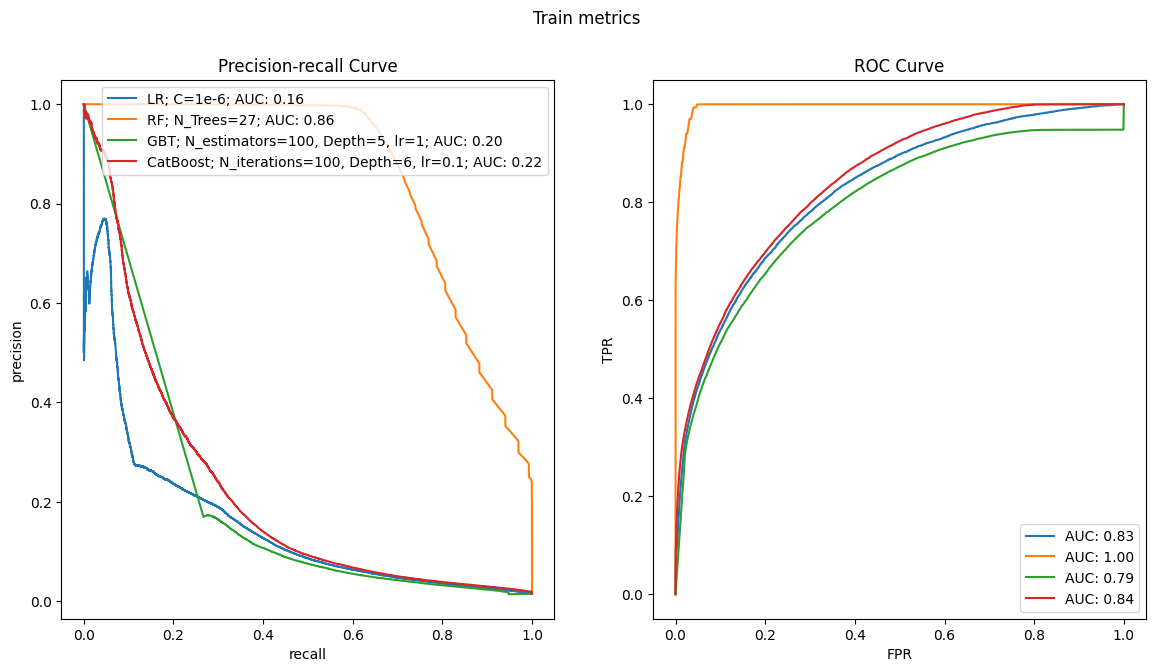

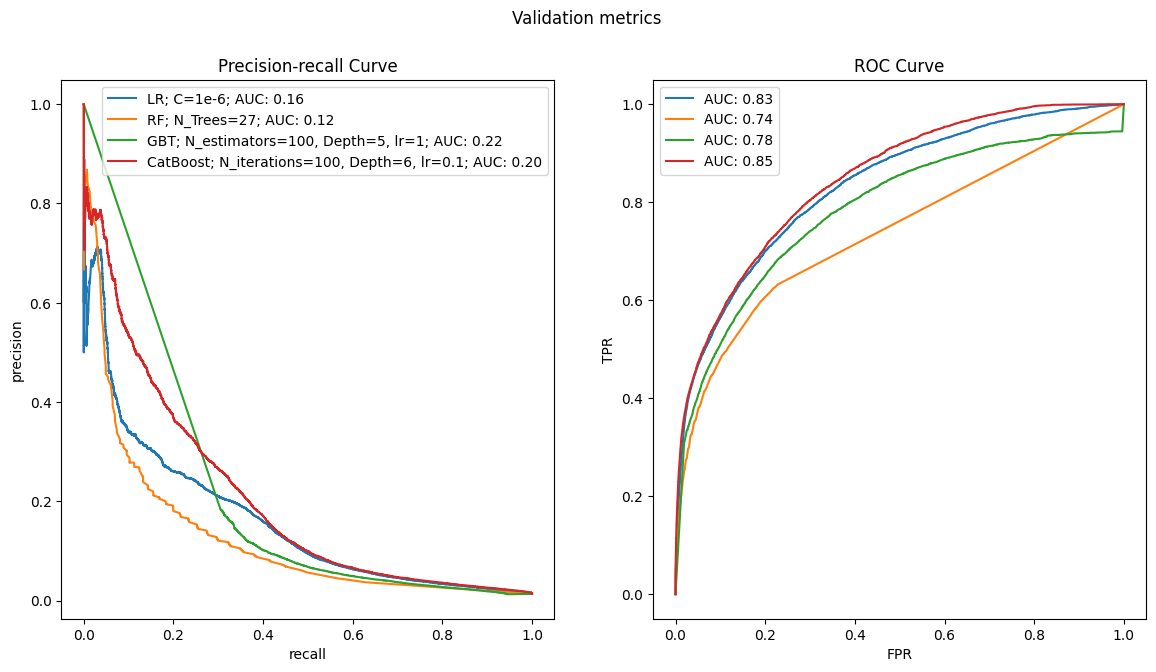

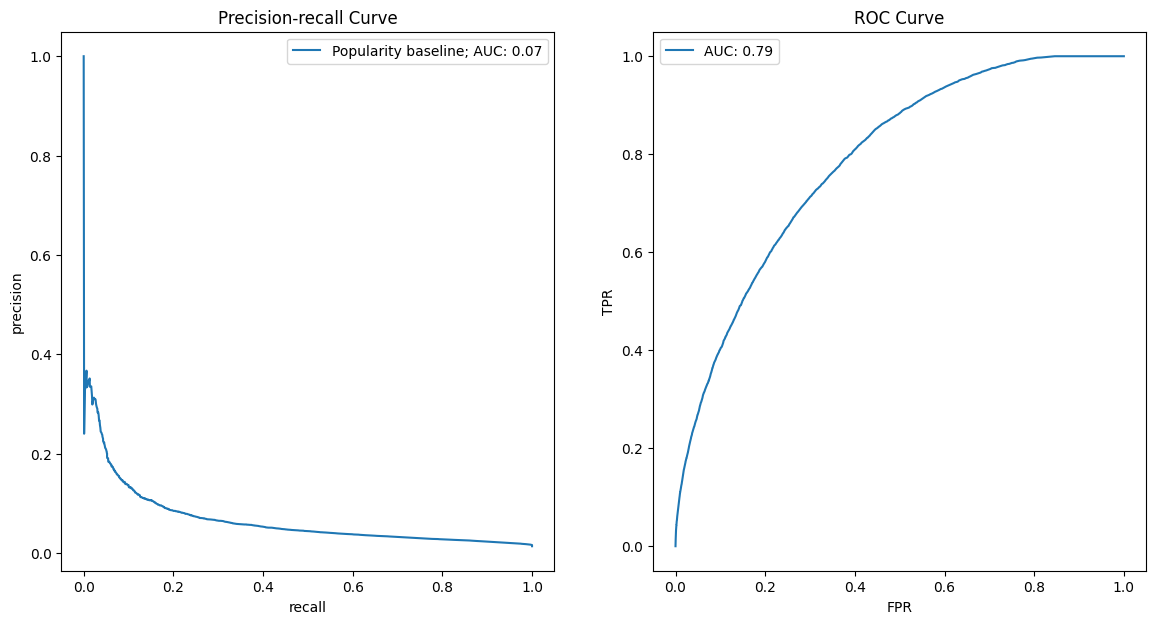

In [34]:
# We initialize the subplots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize = (14,7))
fig2.suptitle("Validation metrics")


# RIDGE    
ridge = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l2", C=1e-6)
)
ridge.fit(X_train[train_cols], y_train)

train_proba = ridge.predict_proba(X_train[train_cols])[:,1]
plot_metrics(f"LR; C=1e-6", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1))


val_proba = ridge.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(f"LR; C=1e-6", y_pred = val_proba, y_test = val_df[label_col], figure = (fig2, ax2))

# RANDOM FOREST

rf = RandomForestClassifier(n_estimators = 50) 
rf.fit(X_train[train_cols], y_train)
train_proba = rf.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(f"RF; N_Trees={n}", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1))


val_proba = rf.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(f"RF; N_Trees={n}", y_pred = val_proba, y_test = val_df[label_col], figure = (fig2, ax2))

# GRADIENT BOOSTING TREES
gbt = GradientBoostingClassifier(
        n_estimators = 100,
        max_depth = 5,
        learning_rate = 1
)
        
gbt.fit(X_train[train_cols], y_train)

train_proba = gbt.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(f"GBT; N_estimators={100}, Depth={5}, lr={1}", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1))


val_proba = gbt.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(f"GBT; N_estimators={100}, Depth={5}, lr={1}", y_pred = val_proba, y_test = val_df[label_col], figure = (fig2, ax2))


# CATBOOST

cbc = CatBoostClassifier(
    learning_rate = 0.1, depth = 6, iterations = 100
)

cbc.fit(X_train[catboost_cols], y_train, categorical_cols)

train_proba = cbc.predict_proba(X_train[catboost_cols])[:, 1]   
plot_metrics(f"CatBoost; N_iterations={100}, Depth={6}, lr={0.1}", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1))


val_proba = cbc.predict_proba(X_val[catboost_cols])[:, 1]
plot_metrics(f"CatBoost; N_iterations={100}, Depth={6}, lr={0.1}", y_pred = val_proba, y_test = val_df[label_col], figure = (fig2, ax2))

# BASELINE

plot_metrics("Popularity baseline", y_pred=val_df["global_popularity"], y_test=val_df[label_col])


## Insights
- Our best model is CatBoost with iterations = 100, depth = 6, learning rate = 0.1
- We got a PR-AUC of 0.20 and a ROC-AUC of 0.85

We save our CatBoost model as a .joblib file

In [40]:
# Create the folder 'models'
models_folder = 'models'
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

In [41]:
# Full file path where we will save our best performing model
file_path = os.path.join(models_folder, 'CatBoost.joblib')

In [42]:
# save the model using joblib
joblib.dump(cbc, file_path)

# Confirm it has been saved
print(f"Model saved in {file_path}")

Model saved in models/CatBoost.joblib


In [47]:
'''file_path = 'models/CatBoost.joblib'

# Load the model from the file
loaded_model = joblib.load(file_path)

# Now, 'loaded_model' contains the model previously saved

# Use example:
train_prediction = loaded_model.predict(train_df[catboost_cols])

print("Prediction result:", train_prediction)'''

'file_path = \'models/CatBoost.joblib\'\n\n# Load the model from the file\nloaded_model = joblib.load(file_path)\n\n# Now, \'loaded_model\' contains the model previously saved\n\n# Use example:\ntrain_prediction = loaded_model.predict(train_df[catboost_cols])\n\nprint("Prediction result:", train_prediction)'